In [31]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize
from pathlib import Path
from data import load_iq
sys.path.insert(0,'/home/gaspar/git/pyhacores/under_construction/fft/')
from under_construction.fft.bit_reversal_fftshift import BitReversal
from under_construction.fft.conjmult import ConjMult
from under_construction.fft.fft_core import R2SDF
from under_construction.fft.windower import Windower

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.mean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.mean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config

In [28]:
fft_points = 512

# Prepare input

In [29]:
inp = load_iq('/home/gaspar/git/pyhacores/data/f2404_fs16.896_one_hop.iq')
inp = signal.decimate(inp, 4)
inp *= 0.5
print(len(inp))
print(inp.max())

# make sure input divides with fft_points
inp = np.array(inp[:int(len(inp) // fft_points) * fft_points])

13472
(0.39532459589201047-0.02449428598414212j)


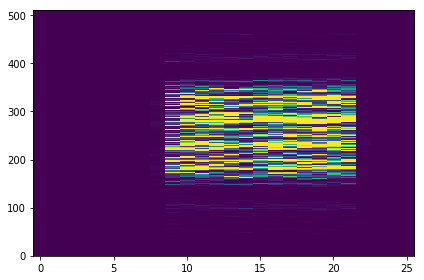

In [32]:
_, _, spectro_out = signal.spectrogram(inp, 1, nperseg=fft_points, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

spectro_out = np.roll(spectro_out, fft_points//2, axis=0)
imshow(spectro_out)

# Apply windowing

In [5]:
dut = Windower(fft_points)

In [6]:
sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'])

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!


/home/gaspar/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


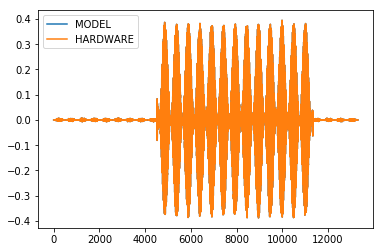

In [7]:
plt.plot(sims['MODEL'], label='MODEL')
plt.plot(sims['PYHA'], label='HARDWARE')
plt.legend()
plt.show()

In [8]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 84.04364741545209


# FFT

In [9]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = R2SDF(fft_points)
sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'])

# fix fft gain
sims['MODEL'] = np.array(sims['MODEL']) * dut.GAIN_CORRECTION

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!


/home/gaspar/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


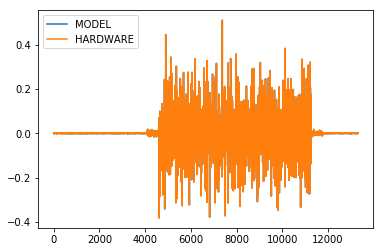

In [10]:
plt.plot(sims['MODEL'], label='MODEL')
plt.plot(sims['PYHA'], label='HARDWARE')
plt.legend()
plt.show()

In [11]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 60.31459810632617


# Bit-reversal and fftshift

In [12]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = BitReversal(fft_points)
sims = simulate(dut, inp, simulations=['MODEL', 'PYHA'])


INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!


/home/gaspar/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


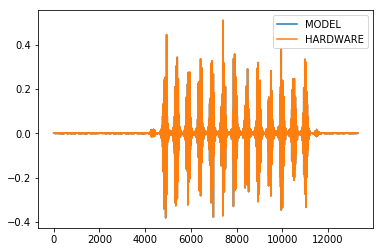

In [13]:
plt.plot(sims['MODEL'], label='MODEL')
plt.plot(sims['PYHA'], label='HARDWARE')
plt.legend()
plt.show()

In [14]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: inf


/home/gaspar/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


# Magnitude

In [15]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = ConjMult()
sims = simulate(dut, inp, simulations=['MODEL_PYHA', 'PYHA'])

INFO:sim:Running "MODEL_PYHA" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!


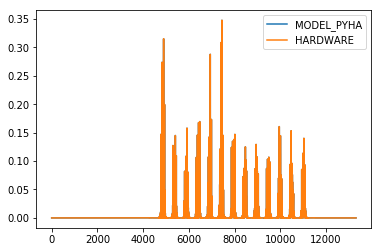

In [16]:
plt.plot(sims['MODEL_PYHA'], label='MODEL_PYHA')
plt.plot(sims['PYHA'], label='HARDWARE')
plt.legend()
plt.show()

In [17]:
snrs = snr(sims['MODEL_PYHA'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 64.34457841338522


# Final evaluation

In [18]:
x = np.array(sims['PYHA']).reshape((-1, fft_points))

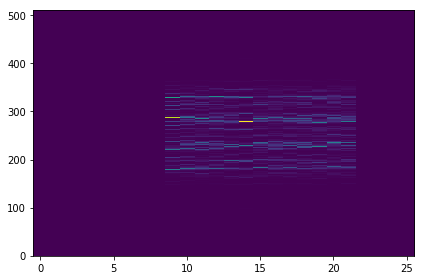

In [19]:
imshow(x.T)

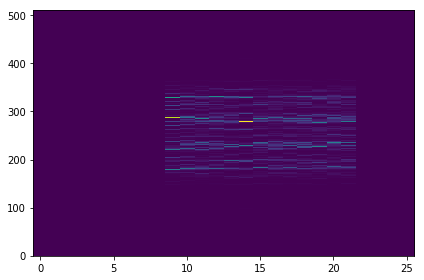

In [20]:
imshow(spectro_out)

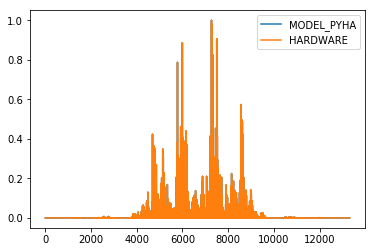

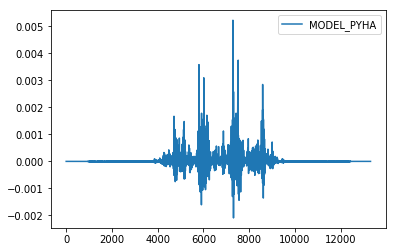

In [21]:
flat_spectro = spectro_out.flatten()
flat_spectro /= spectro_out.max()

flat_pyha = x.T.flatten()
flat_pyha /= flat_pyha.max()

plt.plot(flat_spectro, label='MODEL_PYHA')
plt.plot(flat_pyha, label='HARDWARE')
plt.legend()
plt.show()

plt.plot(flat_pyha - flat_spectro, label='MODEL_PYHA')
plt.legend()
plt.show()


In [22]:
snrs = snr(flat_spectro, flat_pyha)
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 47.28018974309834
